In [3]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import trimesh
from sklearn.decomposition import PCA

#### Loading and Augmenting Data

In [4]:
# ==========================================
# 1. PARTIE CHARGEMENT DES DONNÉES
# ==========================================
def load_femur_data(data_dir="./data"):
    """
    Charge tous les fichiers .obj du dossier et retourne une matrice numpy.
    Format: (Nombre_Femurs, 18291 * 3)
    """
    files = sorted([f for f in os.listdir(data_dir) if f.endswith('.obj')])
    meshes_list = []
    
    print(f"Loading {len(files)} files from {data_dir}...")
    
    for filename in files:
        path = os.path.join(data_dir, filename)
        mesh = trimesh.load(path, process=False) 
        
        # On récupère juste les vertices (sommets)
        # Shape originale : (18291, 3) -> On aplatit en (54873,)
        vertices_flat = mesh.vertices.flatten() 
        meshes_list.append(vertices_flat)
        
    # Conversion en matrice numpy (N_samples, N_features)
    data_matrix = np.array(meshes_list, dtype=np.float32)
    print(f"Data loaded. Final form : {data_matrix.shape}")
    return data_matrix, mesh.faces # On garde les faces pour exporter plus tard


Since Deep Learning requires large amounts of data, we use **Linear PCA** to augment our dataset from 24 to 2,000 samples. 

We generate synthetic femurs by sampling random coordinates in the PCA latent space (based on the learned statistical variance of the original population). This ensures the new shapes remain realistic while providing enough variability for the network to learn.

We model the statistical shape distribution of the femur population using PCA. New samples are generated according to the formula:

$$S_{new} = \bar{S} + \sum_{i=1}^{k} \alpha_i \sqrt{\lambda_i} \mathbf{v}_i$$

Where:
* $\bar{S}$ is the mean shape.
* $\mathbf{v}_i$ are the principal components (modes of deformation).
* $\lambda_i$ are the eigenvalues (explained variance).
* $\alpha_i$ are random coefficients drawn from a normal distribution $\mathcal{N}(0, 1)$.

This allows us to generate **2,000 valid variations** of the femur to train the neural network.

In [ ]:
# ============================
# 2. DATA AUGMENTATION VIA PCA  
# ============================
def generate_synthetic_data(real_data, n_synthetic=2000):
    """
    Utilise une PCA linéaire pour apprendre la forme moyenne
    et les variations, puis génère 2000 nouveaux fémurs plausibles.
    """
    print("--- Data Augmentation Start via PCA ---")
    
    # 1. Fit PCA sur 24 fémurs
    # On garde 99% de la variance pour être très précis
    pca = PCA(n_components=0.99) 
    pca.fit(real_data)
    
    n_components = pca.n_components_
    print(f"PCA a trouvé {n_components} modes de déformation principaux.")
    
    # 2. Générer des vecteurs latents aléatoires (Distribution Gaussienne)
    # On utilise la variance expliquée pour savoir "combien" on peut déformer
    latent_vectors = np.random.normal(
        scale=np.sqrt(pca.explained_variance_), 
        size=(n_synthetic, n_components)
    )
    
    # 3. Reconstruire les fémurs synthétiques
    synthetic_data = pca.inverse_transform(latent_vectors)
    
    print(f"Génération terminée : {synthetic_data.shape} nouveaux fémurs créés.")
    return synthetic_data.astype(np.float32)

#### Autoencoder DeepSSM for Femur Shape Modeling


The model is a feed-forward Autoencoder optimized for 3D coordinate regression.
* **Encoder:** $E: \mathbb{R}^{3N} \rightarrow \mathbb{R}^{32}$
* **Decoder:** $D: \mathbb{R}^{32} \rightarrow \mathbb{R}^{3N}$
* **Layers:** Fully connected (Dense) layers with Batch Normalization.
* **Non-linearity:** `Tanh` activation is strictly used to preserve $C^1$ continuity (smoothness) in the generated mesh and handle centered coordinate systems effectively.

In [ ]:
# ==========================================
# 3. AUTOENCODEUR (Architecture DeepSSM)
# ==========================================
class FemurAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(FemurAutoencoder, self).__init__()
        
        # Encoder : Compresse la forme 3D vers un vecteur z (taille 32)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024), #Pour stabiliser l'entrainement et éviter explosions de gradients
            nn.Tanh(), # Tanh est souvent mieux pour les formes organiques lisses
            nn.Linear(1024, 256),
            nn.Tanh(),
            nn.Linear(256, latent_dim)
        )
        
        # Decoder : Reconstruit la forme 3D depuis z
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 1024),
            nn.Tanh(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

### Training Loop (The Learning Process)

The training loop iterates through the dataset for a defined number of **Epochs**. Each iteration consists of four critical steps:

1.  **Forward Pass :** The input mesh is passed through the network to generate a reconstruction.
2.  **Loss Calculation:** We compute the Mean Squared Error (MSE) between the reconstructed output and the ground truth.
3.  **Backward Pass :** Through **Backpropagation**, we compute the gradients of the loss with respect to the network parameters. This identifies which weights contributed to the error.
4.  **Optimization :** The **Adam optimizer** updates the weights in the opposite direction of the gradients to minimize the error for the next iteration.

In [ ]:
# ==========================================
# 4. MAIN (Exécution)
# ==========================================
if __name__ == "__main__":
    # CONFIG
    DATA_DIR = "./data" 
    LATENT_DIM = 32     # Taille de l'espace réduit (SSM non-linéaire)
    BATCH_SIZE = 32
    EPOCHS = 100
    LR = 1e-4
    
    # A. CHARGEMENT (24 fémurs)
    try:
        real_data, faces = load_femur_data(DATA_DIR)
    except Exception as e:
        print(f"Erreur de chargement: {e}")
        print("Je crée des fausses données pour l'exemple...")
        real_data = np.random.randn(24, 18291*3).astype(np.float32)
        faces = None

    input_dim = real_data.shape[1] # 18291 * 3 = 54873

    # B. AUGMENTATION
    # On crée 2000 exemples pour l'entraînement
    synthetic_data = generate_synthetic_data(real_data, n_synthetic=2000)
    
    # On combine les vrais et les faux pour l'entraînement
    all_data = np.concatenate([real_data, synthetic_data], axis=0)
    
    # Création des tenseurs PyTorch
    dataset = TensorDataset(torch.from_numpy(all_data))
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # C. INITIALISATION DU MODÈLE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FemurAutoencoder(input_dim=input_dim, latent_dim=LATENT_DIM).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss() # Erreur quadratique moyenne (standard pour la reconstruction)

    # D. ENTRAÎNEMENT
    print(f"\n--- Démarrage de l'entraînement sur {device} ---")
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in dataloader:
            x = batch[0].to(device)
            
            # Forward
            x_recon = model(x)
            loss = criterion(x_recon, x)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")

    print("Entraînement terminé.")

    # E. SAUVEGARDE DU MODÈLE
    torch.save(model.state_dict(), "autoencoder_femur.pth")
    print("Modèle sauvegardé sous 'autoencoder_femur.pth'")

    # F. TEST RAPIDE (Inférence)
    # On prend un vrai fémur et on voit si l'AE le reconstruit bien
    model.eval()
    with torch.no_grad():
        test_femur = torch.from_numpy(real_data[0:1]).to(device) # Le premier fémur par exemple
        recon_femur = model(test_femur)
        
        error = criterion(recon_femur, test_femur).item()
        print(f"\nErreur de reconstruction sur un vrai fémur : {error:.6f}")
        
        # Export pour visualiser (optionnel)
        if faces is not None:
            recon_np = recon_femur.cpu().numpy().reshape(-1, 3)
            export_mesh = trimesh.Trimesh(vertices=recon_np, faces=faces)
            export_mesh.export("reconstruction_test.obj")
            print("Fichier 'reconstruction_test.obj' généré pour vérification.")

Loading 24 files from ./data...
Data loaded. Final form : (24, 54873)
--- Data Augmentation Start via PCA ---
PCA a trouvé 12 modes de déformation principaux.
Génération terminée : (2000, 54873) nouveaux fémurs créés.

--- Démarrage de l'entraînement sur cpu ---
Epoch [10/100], Loss: 2695.987896
Epoch [20/100], Loss: 891.765409
Epoch [30/100], Loss: 249.226001
Epoch [40/100], Loss: 78.800472
Epoch [50/100], Loss: 35.935871
Epoch [60/100], Loss: 27.816178
Epoch [70/100], Loss: 21.821909
Epoch [80/100], Loss: 16.745333
Epoch [90/100], Loss: 15.375118
Epoch [100/100], Loss: 15.000429
Entraînement terminé.
Modèle sauvegardé sous 'autoencoder_femur.pth'

Erreur de reconstruction sur un vrai fémur : 45.478107
Fichier 'reconstruction_test.obj' généré pour vérification.


#### Convergence of the autoencoder DeepSSM (Femur) - training loss (MSE)

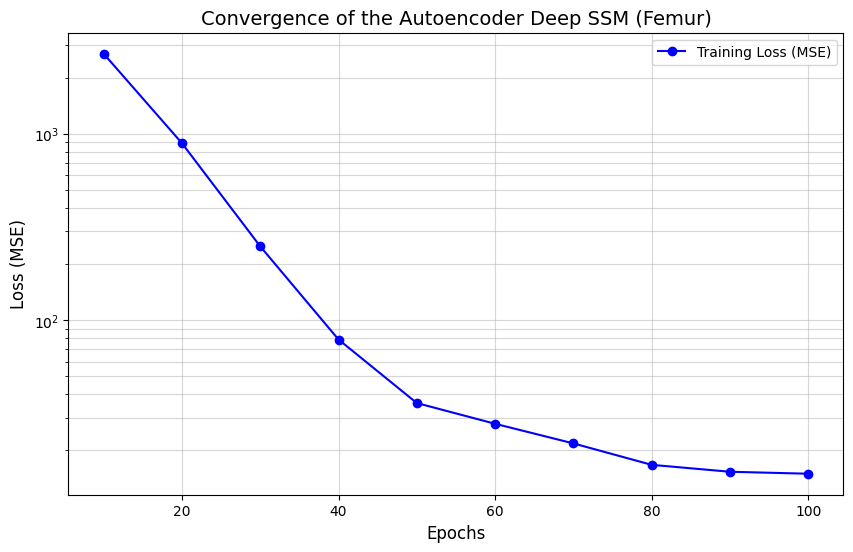

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
loss_values = [2695.98, 891.76, 249.22, 78.80, 35.93, 27.81, 21.82, 16.74, 15.37, 15.00]

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Training Loss (MSE)')

plt.title('Convergence of the Autoencoder Deep SSM (Femur)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()

# Astuce : Comme la chute est très brutale au début, on peut utiliser une échelle logarithmique pour mieux voir la fin de la courbe
plt.yscale('log') 

plt.savefig("courbe_loss_femur.png")
plt.show()

### Step 2: Reconstruction from partial data (occlusions)

To reconstruct a complete femur from sparse or occluded data (e.g., partial observations $Y$), we cannot use the Encoder directly as the input topology is incomplete. Instead, we formulate this as an **optimization problem in the latent space**.

**Methodology:**
We freeze the pre-trained Decoder parameters $\theta$ and search for the optimal latent vector $z^*$ that minimizes the reconstruction error on the *visible vertices* only.

The optimization objective is defined as:

$$z^* = \arg\min_{z} \mathcal{L}_{visible}(D(z), Y)$$

Where:
* $D(z)$ is the full mesh generated by the Decoder from vector $z$.
* $Y$ represents the partial ground-truth coordinates (the observed constraints).
* $\mathcal{L}_{visible}$ is the Mean Squared Error computed **only** on the indices corresponding to $Y$ (masking out the occluded parts).

**Algorithm Implementation:**
1.  **Initialization:** We start with a random latent vector $z \sim \mathcal{N}(0, I)$.
2.  **Freezing:** The Autoencoder weights are frozen (`requires_grad=False`) to preserve the learned anatomical manifold.
3.  **Optimization Loop:** We use the **Adam optimizer** to update $z$ iteratively. At each step, gradients are backpropagated from the masked loss function to the latent vector $z$.

This approach allows the model to "hallucinate" the missing geometry by relying on the statistical correlations learned during the training phase (Phase 1).

In [ ]:
import copy

# --- 1. ON REDÉFINIT LA CLASSE (Obligatoire pour charger le modèle) ---
class FemurAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(FemurAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024), nn.BatchNorm1d(1024), nn.Tanh(),
            nn.Linear(1024, 256), nn.Tanh(), nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.Tanh(),
            nn.Linear(256, 1024), nn.Tanh(), nn.Linear(1024, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# --- 2. FONCTION DE RECONSTRUCTION SOUS CONTRAINTES ---
def solve_partial_reconstruction(model, partial_data, visible_indices, input_dim, device='cpu'):
    """
    On cherche le vecteur z qui minimise l'erreur SEULEMENT sur les points visibles.
    """
    # On gèle le modèle (on ne modifie pas les poids du réseau)
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    
    # On crée un vecteur latent aléatoire z qui sera notre variable à optimiser
    # latent_dim = 32 (comme défini avant)
    z_guess = torch.randn(1, 32, device=device, requires_grad=True)
    
    # On utilise un optimiseur juste pour ce vecteur z
    optimizer = optim.Adam([z_guess], lr=0.1) # Learning rate fort au début
    
    # Les données cibles (ce qu'on voit)
    target_visible = torch.tensor(partial_data, dtype=torch.float32, device=device)
    
    print(f"Optimisation de la forme manquante ({len(visible_indices)} points visibles)...")
    
    # Boucle d'optimisation (Inversion du modèle)
    for i in range(1000):
        optimizer.zero_grad()
        
        # 1. On génère une forme complète depuis notre z actuel
        full_reconstruction = model.decoder(z_guess)
        
        # 2. On extrait seulement les points qui correspondent à ceux visibles
        # Reshape (1, N*3) -> (N, 3)
        rec_reshaped = full_reconstruction.view(-1, 3)
        rec_visible = rec_reshaped[visible_indices] # On prend les points correspondants
        
        # 3. Calcul de l'erreur uniquement sur la partie visible
        loss = torch.mean((rec_visible - target_visible) ** 2)
        
        # Régularisation (Optionnel) : On peut ajouter une pénalité pour éviter des z trop grands
        #loss = loss + 0.001 * torch.mean(z_guess ** 2)
        
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Iter {i}: Error = {loss.item():.4f}")
            
    return model.decoder(z_guess).detach().cpu().numpy()


To assess the reconstruction capabilities of our DeepSSM, we simulate a severe occlusion scenario on **patient #19**.

**Methodological Note on Data Split:**
Given the extreme scarcity of real-world data ($N=24$), we utilized the full dataset to train the PCA and Autoencoder. This strategy maximizes the statistical quality of the learned manifold, which is critical for a Proof of Concept (PoC). Consequently, this validation assesses the model's ability to **retrieve and complete a known anatomical structure** from partial cues (in-distribution testing), rather than its generalization to completely unseen patients.

**Validation Protocol:**
1.  **Ground Truth Loading:** We load the complete mesh of *Femur_19* ($M_{GT}$) which serves as our reference.
2.  **Occlusion Simulation:** We artificially mask the distal part of the femur, keeping only the first 9,000 vertices as "visible" constraints ($Y_{visible}$). The remaining vertices constitute the "hidden" ground truth ($Y_{hidden}$).
3.  **Inference (Latent Optimization):** We run the latent space optimization algorithm (derived in the previous section) to search for the optimal vector $z^*$ that best matches $Y_{visible}$.
4.  **Quantitative Metric:** We compute the **Reconstruction Error** specifically on the hidden part to verify if the model correctly "hallucinated" the missing geometry. The metric is defined as:

$$Error = \frac{1}{N_{hidden}} \sum_{i \in \text{hidden}} \| v_i^{recon} - v_i^{GT} \|_2$$

This allows us to quantify the stability of the latent optimization and the precision of the shape retrieval.

In [ ]:
# --- 3. MAIN ---
if __name__ == "__main__":
    # CONFIG
    MODEL_PATH = "autoencoder_femur.pth" #fichier du modele sauvegardé
    DATA_PATH = "./data/L_Femur_19_DECIM.obj.FINAL.obj" # L'UN des fichiers .obj (n'importe lequel)
    
    
    try:
        print(f"Attempting to load : {DATA_PATH}")
        
        if not os.path.exists(DATA_PATH):
            raise FileNotFoundError(f"The file {DATA_PATH} does not exist !")

        mesh = trimesh.load(DATA_PATH, process=False)
        real_vertices = mesh.vertices
        faces = mesh.faces
        print(f"SUCCESS: Loaded Femur : {DATA_PATH}")
            
    except Exception as e:
        print(f"Loading error: {e}. Check the file name.")
        # Code de secours uniquement si ça plante
        real_vertices = np.random.randn(18291, 3)
        faces = None

    N_verts = real_vertices.shape[0]
    input_dim = N_verts * 3
    
    # A. CHARGEMENT DU MODÈLE
    device = torch.device("cpu") # Sur CPU ça suffit pour l'inférence d'un seul os
    model = FemurAutoencoder(input_dim, latent_dim=32).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("Model successfully loaded")

    # B. CRÉATION D'UNE OCCLUSION (On cache 50% du fémur !)
    # Disons qu'on ne voit que le haut du fémur (indices 0 à 9000)
    # Le reste est "caché" sous la chair ou hors de la radio
    visible_indices = np.arange(0, 9000) 
    
    partial_data = real_vertices[visible_indices] # On ne donne que ça à l'algo
    
    print(f"\n--- Test : Reconstruction with {len(visible_indices)}/{N_verts} points ---")
    
    # C. RÉSOLUTION
    reconstructed_flat = solve_partial_reconstruction(model, partial_data, visible_indices, input_dim, device)
    
    # D. SAUVEGARDE DU RÉSULTAT
    reconstructed_vertices = reconstructed_flat.reshape(-1, 3)
    
    # Calcul de l'erreur sur la partie CACHÉE (La vérité terrain/ground truth)
    hidden_indices = np.arange(9000, N_verts)
    hidden_real = real_vertices[hidden_indices]
    hidden_recon = reconstructed_vertices[hidden_indices]
    error_hidden = np.mean(np.sqrt(np.sum((hidden_real - hidden_recon)**2, axis=1)))
    
    print(f"\nAverage error on the hidden part (Reconstruction) : {error_hidden:.4f} units")
    
    if faces is not None:
        # 1. Sauver le fémur original
        trimesh.Trimesh(vertices=real_vertices, faces=faces).export("original.obj")
        # 2. Sauver le fémur partiel
        # (Astuce : on sauve juste les points visibles comme un nuage de points ou mesh partiel)
        # Pour simplifier, on ne sauve que le résultat reconstruit ici
        # 3. Sauver la reconstruction
        trimesh.Trimesh(vertices=reconstructed_vertices, faces=faces).export("reconstructed_from_partial.obj")
        print("Fichiers 'original.obj' et 'reconstructed_from_partial.obj' créés.")

Attempting to load : ./data/L_Femur_19_DECIM.obj.FINAL.obj
SUCCESS: Loaded Femur : ./data/L_Femur_19_DECIM.obj.FINAL.obj
Model successfully loaded

--- Test : Reconstruction with 9000/18291 points ---
Optimisation de la forme manquante (9000 points visibles)...
Iter 0: Error = 375.4622
Iter 200: Error = 2.3879
Iter 400: Error = 2.3563
Iter 600: Error = 2.3269
Iter 800: Error = 2.3019

Average error on the hidden part (Reconstruction) : 4.6744 units
Fichiers 'original.obj' et 'reconstructed_from_partial.obj' créés.
